## Experimenta con distintos tipos de señales y redes recurrentes

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation
import tensorflow as tf
print tf.__version__
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

1.9.0


In [7]:
def add_noise(x, noise_pct=.1):
    k = (np.max(x)-np.min(x))*noise_pct
    return x + np.random.normal(size=len(x))*k

def timeseries_as_many2one(t, nb_timesteps_in, timelag=1):
    assert timelag>0, "timelag must be >0"
    X,y = [], []
    for i in range(len(t)-nb_timesteps_in-timelag):
        X.append(t[i:i+nb_timesteps_in])
        y.append(t[i+nb_timesteps_in+timelag-1])
    return np.r_[X].reshape(-1, nb_timesteps_in, 1), np.r_[y].reshape(-1,1)

## Varias señales de ejemplo

- observa como `s1` contiene una señal y `ns1` tiene la misma señal con ruido añadido
- experimenta con distintos niveles de ruido `noise_pct`

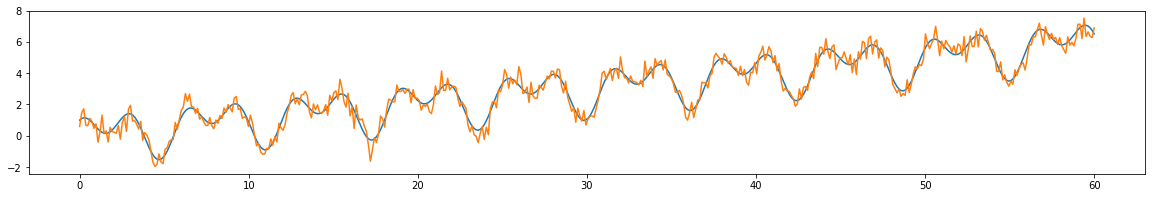

In [9]:
t1 = np.linspace(0,60,500)
s1 = np.sin(t1)+np.cos(2*t1)+t1/10
ns1 = add_noise(s1,noise_pct=.05)
plt.figure(figsize=(20,3))
plt.plot(t1,s1)
plt.plot(t1,ns1)

**una señal un poco más compleja**

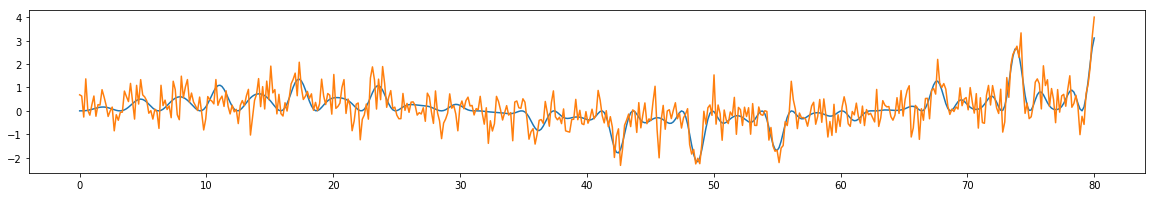

In [10]:
t2 = np.linspace(0,80,500)
s2 = (np.sin(t2)+np.cos(2*t2)*t2/100)**2*np.sin(t2/10)
ns2 = add_noise(s2,noise_pct=.1)
plt.figure(figsize=(20,3))
plt.plot(t2,s2)
plt.plot(t2,ns2)

**una señal de un dataset: daily exchange rate USD/MXN**

In [16]:
import pandas as pd
d = pd.read_csv("data/CURRFX-USDMXN.csv.gz")
d.index = pd.to_datetime(d.Date)
d.head()

,Date,Rate,High (est),Low (est)
Date,,,,
2017-03-16,2017-03-16,19.230000,19.233000,19.198999
2017-03-15,2017-03-15,19.232800,19.674500,19.179501
2017-03-14,2017-03-14,19.655001,19.721201,19.570400
2017-03-13,2017-03-13,19.617201,19.656000,19.538300
2017-03-10,2017-03-10,19.597000,19.872601,19.563999


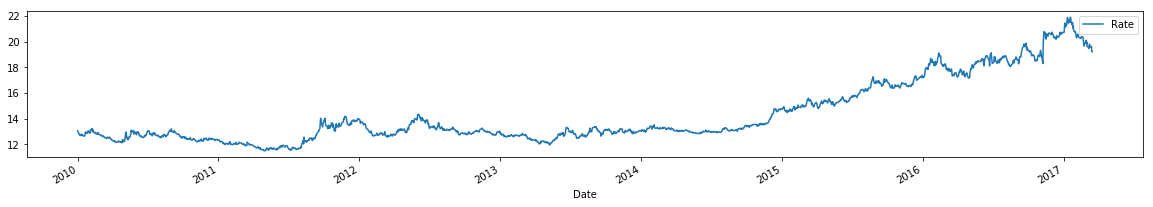

In [18]:
s3 = d.Rate.values[::-1]
d[["Rate"]].plot(figsize=(20,3))

## Construye o carga otras señales temporales

## Paso 1: Decide qué tipo de tarea quieres realizar

- _sugerencia_: inicia con una tarea **many to one**

## Paso 2: Construye el dataset desde la señal

- no te olvides de revisar si los tamaños (`shape`) de los objetos es el adecuado


In [33]:
X,y = timeseries_as_many2one(ns2, nb_timesteps_in=20, timelag=1)
i = int(len(X)*2./3)
Xtr, ytr = X[:i], y[:i]
Xts, yts = X[i:], y[i:]
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((319, 20, 1), (160, 20, 1), (319, 1), (160, 1))

## Paso 3: Construye el modelo de red recurrente

In [34]:
def get_many2one_single_layer_LSTM(n_neurons, nb_timesteps_in):
    # create LSTM
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(nb_timesteps_in, 1),recurrent_activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mape"])
    return model

In [35]:
model = get_many2one_single_layer_LSTM(n_neurons=30, nb_timesteps_in=X.shape[1])

## Pase 4: Entrena tu modelo

In [36]:
model.fit(Xtr, ytr, epochs=15, batch_size=10, verbose=1, validation_data=(Xts, yts))

Train on 319 samples, validate on 160 samples
Epoch 1/15
319/319 [==============================] - 2s 6ms/step - loss: 0.4799 - mean_absolute_percentage_error: 150.7413 - val_loss: 0.6809 - val_mean_absolute_percentage_error: 142.4829
Epoch 2/15
319/319 [==============================] - 1s 2ms/step - loss: 0.4244 - mean_absolute_percentage_error: 241.3844 - val_loss: 0.6487 - val_mean_absolute_percentage_error: 158.2689
Epoch 3/15
319/319 [==============================] - 1s 2ms/step - loss: 0.4058 - mean_absolute_percentage_error: 247.7760 - val_loss: 0.6408 - val_mean_absolute_percentage_error: 145.4642
Epoch 4/15
319/319 [==============================] - 1s 2ms/step - loss: 0.3976 - mean_absolute_percentage_error: 245.7754 - val_loss: 0.6208 - val_mean_absolute_percentage_error: 152.7705
Epoch 5/15
319/319 [==============================] - 1s 3ms/step - loss: 0.3881 - mean_absolute_percentage_error: 252.4041 - val_loss: 0.6069 - val_mean_absolute_percentage_error: 148.4682
Epoc

## Paso 5: Mide desempeño y pinta la salida

In [37]:
yts_preds = model.predict(Xts)
yts_preds.shape
print "trend accuracy %.2f"%(np.mean( (yts_preds[1:]>yts_preds[:-1])==(yts[1:]>yts[:-1])))

trend accuracy 0.37


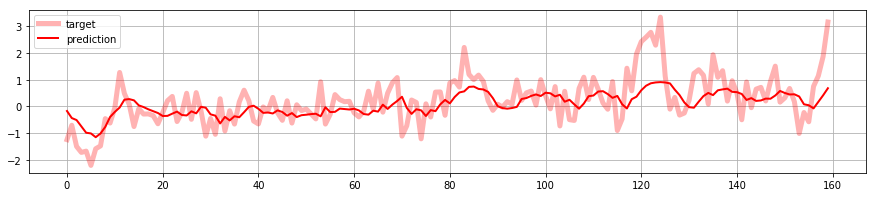

In [38]:
plt.figure(figsize=(15,3))
plt.plot(yts[:,0], color="red", alpha=.3, lw=5, label="target")
plt.plot(yts_preds[:,0], color="red", alpha=1, lw=2, label="prediction")
plt.legend()
plt.grid()